# PREDICTING  THE PROBABLITY OF RECESSIONS FROM US TREASURY SPREADS

The question we will be trying to answer is, "What is the probability that the U.S. will be in a recession 12 months from now?". 

A few notes concerning the problem at hand:
1. We have assumed that US treasury markets contain information about the future path of the US economy.
2. We must assume that the past relationship between US Treasuries and the US economy will be retained.

On the data:
1. The data is unbalanced, as recessions are rare events.
2. This is a time series, so simple cross-validation will likely not be optimal.

On the statistical model:
-	 We will utilize a probit model. In statistics, a probit model is a type of regression where the dependent variable can take only two values, for example, "recession" or "no recession." The probit model is a good fit for this problem as it gives a probability of recession between 0 and 1.  Logistic and probit models are similar but differ in the link function. Logistic assumes the distribution is logistic, while probit assumes the underlying distribution is normal. The difference in the distribution leads to different interpretations and error distributions. Probit has slightly fatter tails than logit.




In [18]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

plt.style.use('default')
pd.options.display.float_format = '{:20,.6f}'.format

## IMPORT & CLEAN THE DATA

In [19]:
fill_color_1 = "#b1b59a"
fill_color_2 = "r"
fill_USREC = "US Recession"

In [20]:
# https://fred.stlouisfed.org/release/tables?rid=18&eid=289#snid=323
# https://fred.stlouisfed.org/release/tables?rid=18&eid=291#snid=423

start_date = "1934-01-01"
end_date = "4-30-2024"

# US TREASURY  ----------------------------------------------------------------------------------------------------------------------------------

FEDFUNDS_Data = pdr.get_data_fred("FEDFUNDS", start = start_date, end = end_date) # Federal Funds Effective Rate (FEDFUNDS) Start: 1954
TB3MS_Data = pdr.get_data_fred("TB3MS", start = start_date, end = end_date) # 3-Month Treasury Bill Secondary Market Rate, Discount Basis (TB3MS) Start: 1934
GS1_Data = pdr.get_data_fred("GS1", start = start_date, end = end_date) # Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (GS1) Start: 1953
GS3_Data = pdr.get_data_fred("GS3", start = start_date, end = end_date) # Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (GS3) Start: 1953
GS5_Data = pdr.get_data_fred("GS5", start = start_date, end = end_date) # Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (GS5) Start: 1953
GS10_Data = pdr.get_data_fred("GS10", start = start_date, end = end_date) # Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (GS10) Start: 1953

USREC_Data = pdr.get_data_fred("USREC", start = start_date, end = end_date) # NBER based Recession Indicators for the United States from the Period following the Peak through the Trough (USREC)

In [21]:
FEDFUNDS_M = FEDFUNDS_Data.resample("ME").last()
TB3MS_M = TB3MS_Data.resample("ME").last()
GS1_M = GS1_Data.resample("ME").last()
GS3_M = GS3_Data.resample("ME").last()
GS5_M = GS5_Data.resample("ME").last()
GS10_M = GS10_Data.resample("ME").last()

USREC_M = USREC_Data.resample("ME").last()

FRED_M = pd.concat([FEDFUNDS_M, TB3MS_M, GS1_M, GS3_M, GS5_M, GS10_M], axis = 1).copy()
FRED_M.columns = ["FedRate", "3M", "1Y", "3Y", "5Y", "10Y"]

In [22]:
UST_3M_FR = (FRED_M["3M"] - FRED_M["FedRate"])

UST_1Y_FR = (FRED_M["1Y"] - FRED_M["FedRate"])
UST_1Y_3M = (FRED_M["1Y"] - FRED_M["3M"])

UST_3Y_FR = (FRED_M["3Y"] - FRED_M["FedRate"])
UST_3Y_3M = (FRED_M["3Y"] - FRED_M["3M"])
UST_3Y_1Y = (FRED_M["3Y"] - FRED_M["1Y"])

UST_5Y_FR = (FRED_M["5Y"] - FRED_M["FedRate"])
UST_5Y_3M = (FRED_M["5Y"] - FRED_M["3M"])
UST_5Y_1Y = (FRED_M["5Y"] - FRED_M["1Y"])
UST_5Y_3Y = (FRED_M["5Y"] - FRED_M["3Y"])

UST_10Y_FR = (FRED_M["10Y"] - FRED_M["FedRate"])
UST_10Y_3M = (FRED_M["10Y"] - FRED_M["3M"])
UST_10Y_1Y = (FRED_M["10Y"] - FRED_M["1Y"])
UST_10Y_3Y = (FRED_M["10Y"] - FRED_M["3Y"])
UST_10Y_5Y = (FRED_M["10Y"] - FRED_M["5Y"])

FRED_YCV_M = pd.concat([UST_3M_FR, UST_1Y_FR, UST_1Y_3M, UST_3Y_FR, UST_3Y_3M, UST_3Y_1Y, UST_5Y_FR, UST_5Y_3M, UST_5Y_1Y, UST_5Y_3Y,\
                       UST_10Y_FR, UST_10Y_3M, UST_10Y_1Y, UST_10Y_3Y, UST_10Y_5Y], axis = 1)

FRED_YCV_M.columns =  ["UST_3M_FR", "UST_1Y_FR", "UST_1Y_3M", "UST_3Y_FR", "UST_3Y_3M", "UST_3Y_1Y", "UST_5Y_FR", "UST_5Y_3M", "UST_5Y_1Y", "UST_5Y_3Y",\
                        "UST_10Y_FR", "UST_10Y_3M", "UST_10Y_1Y", "UST_10Y_3Y", "UST_10Y_5Y"]

data = pd.concat([FRED_YCV_M, USREC_M], axis = 1).interpolate().dropna()

data

,UST_3M_FR,UST_1Y_FR,UST_1Y_3M,UST_3Y_FR,UST_3Y_3M,UST_3Y_1Y,UST_5Y_FR,UST_5Y_3M,UST_5Y_1Y,UST_5Y_3Y,UST_10Y_FR,UST_10Y_3M,UST_10Y_1Y,UST_10Y_3Y,UST_10Y_5Y,USREC
DATE,,,,,,,,,,,,,,,,
1954-07-31,-0.080000,0.040000,0.120000,0.670000,0.750000,0.630000,1.050000,1.130000,1.010000,0.380000,1.500000,1.580000,1.460000,0.830000,0.450000,0
1954-08-31,-0.300000,-0.340000,-0.040000,0.270000,0.570000,0.610000,0.680000,0.980000,1.020000,0.410000,1.140000,1.440000,1.480000,0.870000,0.460000,0
1954-09-30,-0.060000,-0.040000,0.020000,0.530000,0.590000,0.570000,0.890000,0.950000,0.930000,0.360000,1.310000,1.370000,1.350000,0.780000,0.420000,0
1954-10-31,0.130000,0.320000,0.190000,0.870000,0.740000,0.550000,1.170000,1.040000,0.850000,0.300000,1.580000,1.450000,1.260000,0.710000,0.410000,0
1954-11-30,0.100000,0.310000,0.210000,0.920000,0.820000,0.610000,1.260000,1.160000,0.950000,0.340000,1.650000,1.550000,1.340000,0.730000,0.390000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,-0.090000,-0.370000,-0.280000,-1.140000,-1.050000,-0.770000,-1.330000,-1.240000,-0.960000,-0.190000,-1.310000,-1.220000,-0.940000,-0.170000,0.020000,0
2024-01-31,-0.110000,-0.540000,-0.430000,-1.220000,-1.110000,-0.680000,-1.350000,-1.240000,-0.810000,-0.130000,-1.270000,-1.160000,-0.730000,-0.050000,0.080000,0
2024-02-29,-0.090000,-0.410000,-0.320000,-1.000000,-0.910000,-0.590000,-1.140000,-1.050000,-0.730000,-0.140000,-1.120000,-1.030000,-0.710000,-0.120000,0.020000,0


#### VISUALIZING THE DATA

First, let's examine the correlation between our features (US Treasury Spreads):

<Axes: >

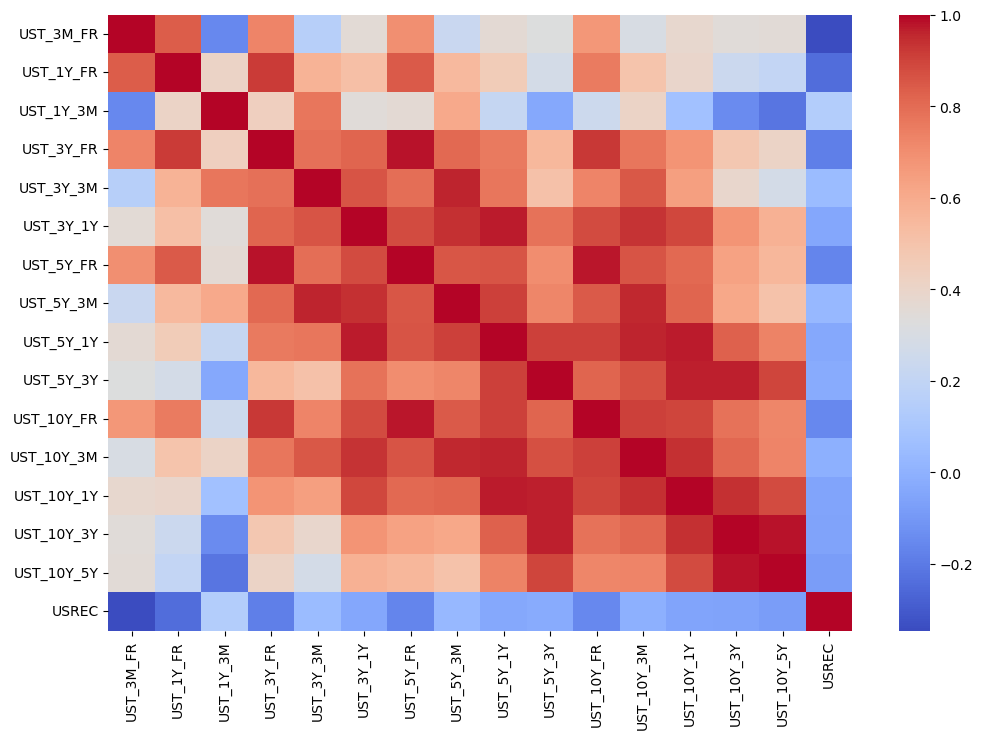

In [23]:
import seaborn as sns

corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', ax =ax)

Not surprising that a lot of the US treasury spreads are positively correlated. Also, all the spreads are low or negatively correlated with recessions. Let's sample a few spreads (3-Year Minus Federal Fund Rate, 5-Year Minus 1-Year, and 10-Year Minus 3-Month).

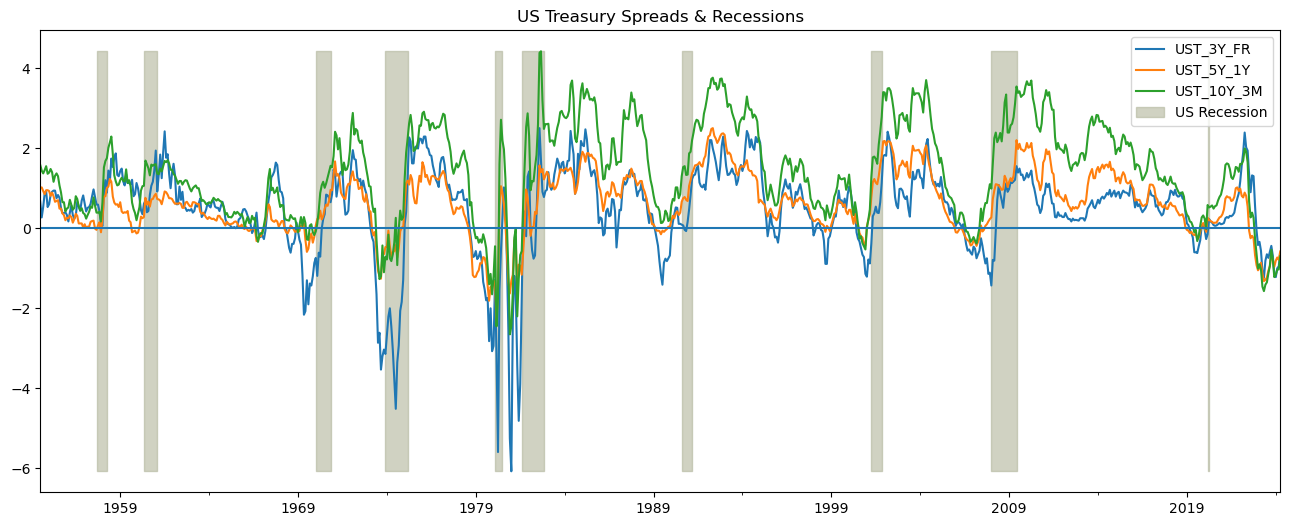

In [24]:
ax = data[["UST_3Y_FR", "UST_5Y_1Y", "UST_10Y_3M"]].plot(title = "US Treasury Spreads & Recessions", figsize=(16, 6))

fill_range = data["USREC"]
max_y = data[["UST_10Y_3M"]].max()
min_y = data[["UST_3Y_FR"]].min()
ax.fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax.set_xlabel("")
ax.axhline(0)
plt.legend()

The data is not balanced, meaning there are no recessions most of the time. To be specific, about 12% of the data is labeled as recession.

In [25]:
perc_m_in_rec = data["USREC"].sum() / data["USREC"].count()
print("Percetange of Months in Recession:", round(perc_m_in_rec,2)*100 , "%")

Percetange of Months in Recession: 12.0 %


#### FEATURE SELECTION

Since we have a target variable (Recession = 1, No Recession = 0), we will use supervised feature selection techniques to decide which yield spread to select for our predictive model. Since the data is a time series, some methods will work better than others. We will use filter feature selection methods. Such statistical techniques help evaluate the relationship between each input variable and the target variable, and their scores are used as the basis to choose (filter) those input variables that will be used in the model.

Given current treasury spreads, we will be trying to predict the future probability of recession, which means that we need the lagged variables of our features (US Treasury Spreads). We will have a 12-month lag since we are trying to see if a recession will likely occur within a year.


In [26]:
X = data.drop(columns = "USREC")
shift_n = 12
X_shifted_12M = X.shift(shift_n).dropna()

y = data.loc[X_shifted_12M.index[0]:, "USREC"]

### SPLITING THE TIME SERIES

We manually split the data to avoid bad splits (for example:  mid-recession). We will also use block splitting, which helps avoid data leakage issues. Below is a visual of how the blocks are broken down. In the case of time series, the cross-validation is not trivial. We cannot choose random samples and assign them to either the test set or the train set because it makes no sense to use future values to forecast past values. In simple words, we want to avoid future-looking when we train our model. There is a temporal dependency between observations, and we must preserve that relation during testing.

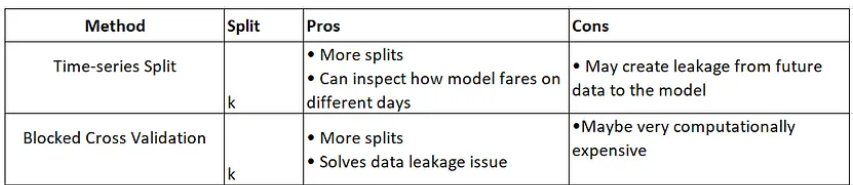

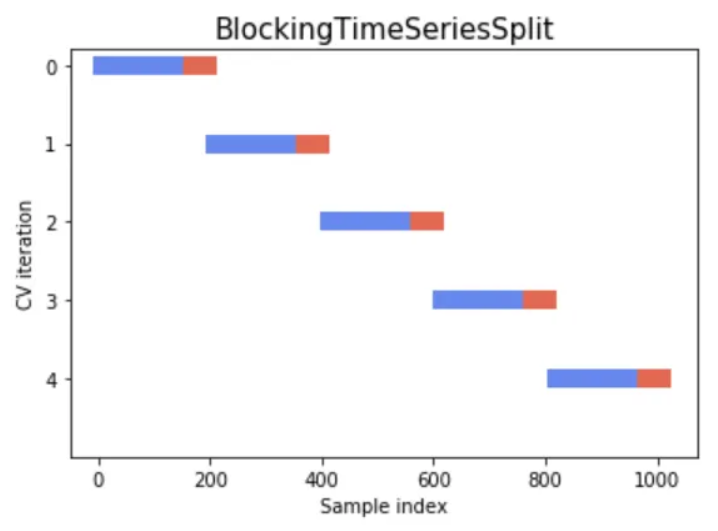

Below is how the data was split manually. There will be seven splits, some of which will include two recessions and others just one. We have avoided splitting mid-recession.

Text(0.5, 0, '')

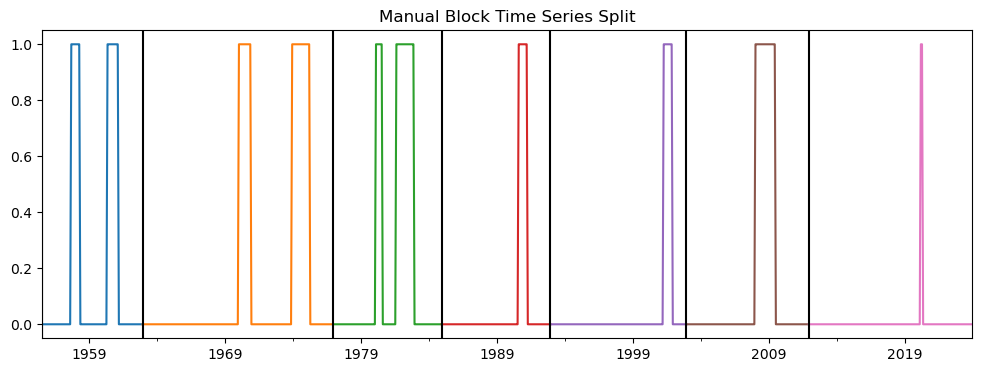

In [27]:
time_split_dates = ["1955-07-31", "1962-12-31", "1976-12-31", "1984-12-31", "1992-12-31", "2002-12-31", "2011-12-31", "2023-12-31"]

data.loc[time_split_dates[0]:time_split_dates[1]]["USREC"].plot(figsize = (12,4))
data.loc[time_split_dates[1]:time_split_dates[2]]["USREC"].plot()
data.loc[time_split_dates[2]:time_split_dates[3]]["USREC"].plot()
data.loc[time_split_dates[3]:time_split_dates[4]]["USREC"].plot()
data.loc[time_split_dates[4]:time_split_dates[5]]["USREC"].plot()
data.loc[time_split_dates[5]:time_split_dates[6]]["USREC"].plot()
data.loc[time_split_dates[6]:time_split_dates[7]]["USREC"].plot()

plt.axvline(x=time_split_dates[0], color = "black")
plt.axvline(x=time_split_dates[1], color = "black")
plt.axvline(x=time_split_dates[2], color = "black")
plt.axvline(x=time_split_dates[3], color = "black")
plt.axvline(x=time_split_dates[4], color = "black")
plt.axvline(x=time_split_dates[5], color = "black")
plt.axvline(x=time_split_dates[6], color = "black")

plt.title("Manual Block Time Series Split")
plt.xlabel("")

Every subsequent block will be the test block. For example, the first block will be the training data, the second block will be the test data, the second block will be the training data, and the third block will be the test data, etc. 

In [28]:
ts_block_dates = {"TS1": {"Train" : [time_split_dates[0], time_split_dates[1]], "Test": [time_split_dates[1], time_split_dates[2]]}, \
                "TS2": {"Train" : [time_split_dates[1], time_split_dates[2]], "Test": [time_split_dates[2], time_split_dates[3]]}, \
                "TS3": {"Train" : [time_split_dates[2], time_split_dates[3]], "Test": [time_split_dates[3], time_split_dates[4]]}, \
                "TS4": {"Train" : [time_split_dates[3], time_split_dates[4]], "Test": [time_split_dates[4], time_split_dates[5]]}, \
                "TS5": {"Train" : [time_split_dates[4], time_split_dates[5]], "Test": [time_split_dates[5], time_split_dates[6]]}, \
                "TS6": {"Train" : [time_split_dates[5], time_split_dates[6]], "Test": [time_split_dates[6], time_split_dates[7]]},
}

print(ts_block_dates)

{'TS1': {'Train': ['1955-07-31', '1962-12-31'], 'Test': ['1962-12-31', '1976-12-31']}, 'TS2': {'Train': ['1962-12-31', '1976-12-31'], 'Test': ['1976-12-31', '1984-12-31']}, 'TS3': {'Train': ['1976-12-31', '1984-12-31'], 'Test': ['1984-12-31', '1992-12-31']}, 'TS4': {'Train': ['1984-12-31', '1992-12-31'], 'Test': ['1992-12-31', '2002-12-31']}, 'TS5': {'Train': ['1992-12-31', '2002-12-31'], 'Test': ['2002-12-31', '2011-12-31']}, 'TS6': {'Train': ['2002-12-31', '2011-12-31'], 'Test': ['2011-12-31', '2023-12-31']}}


## SCORING THE FEATURES

We will examine the success of the given feature using four different metrics:

1. Accuracy Score - This function computes subset accuracy, the set of labels predicted for a sample must match the corresponding set of labels in y_true.
2. Balanced Accuracy Score - The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average recall obtained on each class.
3. F1 Score - A higher F1 score indicates that the model is better at correctly identifying both positive and negative instances, with a good balance between precision and recall.
4. Log Loss Score - It considers the distance between the predicted probability of class = “1” and the actual class value (“1” or “0”). Log loss assigns an exponentially heavier penalty to larger discrepancies between predicted probabilities and actual class output.

We assign a probability break point to anything above 0.3. This means that a recessionary indicator is whenever a feature probability of recession exceeds 0.3.

<Axes: title={'center': 'Log Loss Score (Lower is Better)'}>

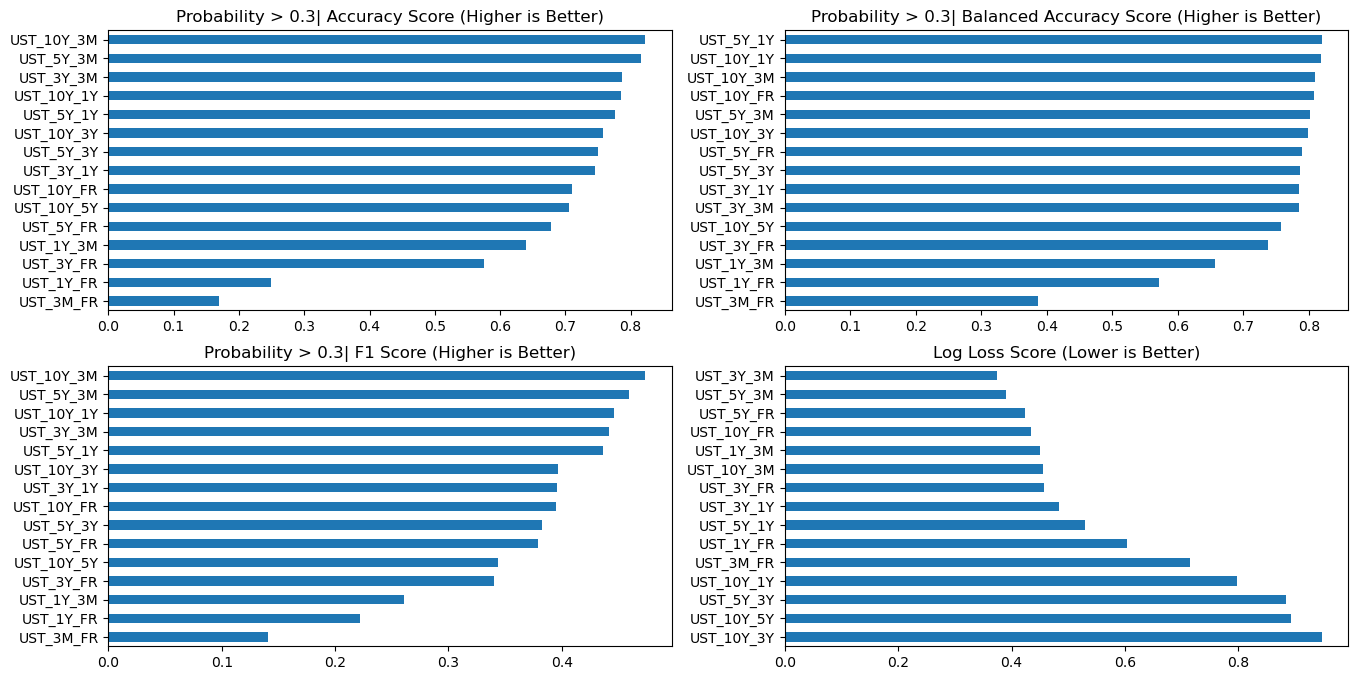

In [29]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, log_loss

prob_bp = 0.3
ac_score_d = {}
bac_score_d = {}
f1_score_d = {}

logl_score_d = {}

features = X.columns
for col in features:

    ac_scores = []  # List to store scores for each split
    bac_scores = []  # List to store scores for each split
    f1_scores = []
    logl_scores = []

    for ts_split in ts_block_dates.values():

        X_train = X_shifted_12M.loc[ts_split["Train"][0]:ts_split["Train"][1], [col]]
        y_train = y[ts_split["Train"][0]:ts_split["Train"][1]]

        X_test = X_shifted_12M.loc[ts_split["Test"][0]:ts_split["Test"][1], [col]]
        y_test = y[ts_split["Test"][0]:ts_split["Test"][1]]

        model = sm.Probit(exog = X_train, endog = y_train).fit(disp=0)  # Train your model with X[train_index] and y[train_index]

        prob_pred = model.predict(X_test[col])
        logl_scores.append(log_loss(y_true = y_test, y_pred = prob_pred))

        y_pred = (prob_pred > prob_bp).astype("int")
        ac_scores.append(accuracy_score(y_true = y_test, y_pred = y_pred))
        bac_scores.append(balanced_accuracy_score(y_true = y_test, y_pred = y_pred))
        f1_scores.append(f1_score(y_true = y_test, y_pred = y_pred))

    ac_score_d[col] = ac_scores
    bac_score_d[col] = bac_scores
    f1_score_d[col] = f1_scores
    logl_score_d[col] = logl_scores


accuracy_cv_mean_score = pd.DataFrame.from_dict(ac_score_d).mean().sort_values(ascending = True)
accuracy_cv_mean_score.name = "Accuracy Score"

bal_accuracy_cv_mean_score = pd.DataFrame.from_dict(bac_score_d).mean().sort_values(ascending = True)
bal_accuracy_cv_mean_score.name = "Balanced Accuracy Score"

f1_cv_mean_score = pd.DataFrame.from_dict(f1_score_d).mean().sort_values(ascending = True)
f1_cv_mean_score.name = "F1 Score"

logloss_cv_mean_score = pd.DataFrame.from_dict(logl_score_d).mean().sort_values(ascending = False)
logloss_cv_mean_score.name = "LogLoss Score"

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 8))
accuracy_cv_mean_score.plot(ax = ax[0,0],kind = "barh", title = "Probability > " + str(prob_bp) + "| Accuracy Score (Higher is Better)")
bal_accuracy_cv_mean_score.plot(ax = ax[0,1],kind = "barh", title = "Probability > " + str(prob_bp) + "| Balanced Accuracy Score (Higher is Better)")
f1_cv_mean_score.plot(ax = ax[1,0], kind = "barh", title = "Probability > " + str(prob_bp) +"| F1 Score (Higher is Better)")
logloss_cv_mean_score.plot(ax = ax[1,1], kind = "barh", title = "Log Loss Score (Lower is Better)")

Let's visualize the probit probability function of the higher rank candidates from each type of performance metric:

Text(0.5, 0, '')

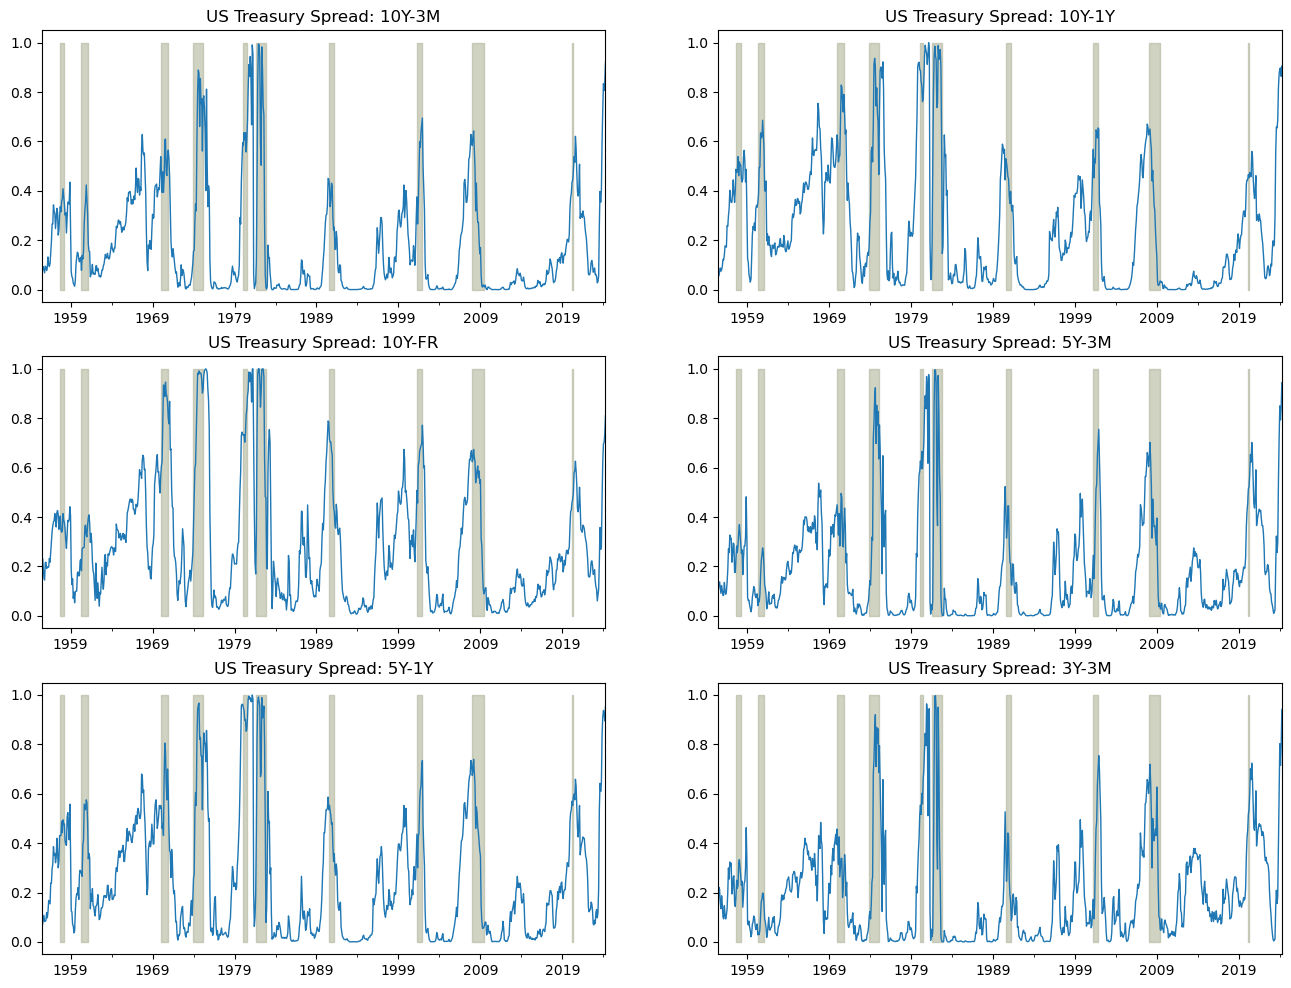

In [30]:
top_features = ["UST_10Y_3M", "UST_10Y_1Y", "UST_10Y_FR", "UST_5Y_3M", "UST_5Y_1Y", "UST_3Y_3M"] 
top_feature_prob_d = {}

for feature in top_features:

    model = sm.Probit(exog = X_shifted_12M[feature], endog = y).fit(disp=0)
    prob_pred = model.predict(X_shifted_12M[feature])
    top_feature_prob_d[feature] = prob_pred

top_features_prob_df = pd.DataFrame.from_dict(top_feature_prob_d)

fig, ax = plt.subplots(nrows=3, ncols=2, figsize = (16, 12))

top_features_prob_df["UST_10Y_3M"].plot(title = "US Treasury Spread: 10Y-3M", ax =ax[0,0], linewidth=1)
top_features_prob_df["UST_10Y_1Y"].plot(title = "US Treasury Spread: 10Y-1Y", ax =ax[0,1], linewidth=1)
top_features_prob_df["UST_10Y_FR"].plot(title = "US Treasury Spread: 10Y-FR", ax =ax[1,0], linewidth=1)
top_features_prob_df["UST_5Y_3M"].plot(title = "US Treasury Spread: 5Y-3M", ax =ax[1,1], linewidth=1)
top_features_prob_df["UST_5Y_1Y"].plot(title = "US Treasury Spread: 5Y-1Y", ax =ax[2,0], linewidth=1)
top_features_prob_df["UST_3Y_3M"].plot(title = "US Treasury Spread: 3Y-3M", ax =ax[2,1], linewidth=1)


fill_range = y
max_y = 1
min_y = 0

ax[0,0].fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax[0,1].fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax[1,0].fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax[1,1].fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax[2,0].fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax[2,1].fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)

ax[0,0].set_xlabel("")
ax[0,1].set_xlabel("")
ax[1,0].set_xlabel("")
ax[1,1].set_xlabel("")
ax[2,0].set_xlabel("")
ax[2,1].set_xlabel("")

All the selected US Treasury spreads appear to have predictive power. Visually, the primary false signal seems to be the spread probability during the late 1960s and mid-1990s. Some indicators appear to be more volatile than others.

In [31]:
top_features_prob_df[top_features].describe()

,UST_10Y_3M,UST_10Y_1Y,UST_10Y_FR,UST_5Y_3M,UST_5Y_1Y,UST_3Y_3M
count,826.000000,826.000000,826.000000,826.000000,826.000000,826.000000
mean,0.181479,0.255858,0.295062,0.183807,0.260633,0.193716
std,0.216734,0.255554,0.252710,0.210296,0.252596,0.202296
min,0.000011,0.000128,0.006743,0.000000,0.000136,0.000000
25%,0.011069,0.033173,0.088119,0.023628,0.042849,0.036726
50%,0.087630,0.177543,0.223495,0.096847,0.179434,0.125863
75%,0.295167,0.431699,0.428071,0.282611,0.423492,0.294815
max,0.994576,0.999519,0.999985,0.995173,0.999690,0.996639


Next, let's examine more statistical measures on the full data set, such as AIC, BIC, and Pseudo R-squared.

- AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are both penalized likelihood criteria used in model selection. They balance model complexity with its ability to fit the data, helping you choose the model that best generalizes to unseen data. While they share similarities, their penalty terms and preferred outcomes differ. AIC applies a less severe penalty based on the number of parameters (2k), where k is the number of parameters. BIC applies a more substantial penalty based on the number of parameters and the sample size (ln(n)*k), where n is the sample size. AIC generally favors more complex models that fit the data well, especially with smaller datasets. BIC prefers simpler models that avoid overfitting, particularly with larger datasets. AIC might be more appropriate for smaller datasets due to its less stringent penalty. If you're concerned about overfitting and want a more parsimonious model, BIC is a safer choice. If you need a model that captures all the intricacies of the data, AIC might be better.

- Pseudo R-squared measures the improvement in the fit of a probit regression model due to the independent variables.


In [32]:
features=  X_shifted_12M.columns
bic_d = {}
aic_d = {}
psR_d = {}

for feature in features:
    model = sm.Probit(endog = y, exog = X_shifted_12M[feature]).fit(disp=0)

    bic_d[feature] = model.bic
    aic_d[feature] = model.aic
    psR_d[feature] = model.prsquared

probit_stats = pd.DataFrame.from_dict({"Pseudo R-squared": psR_d, "BIC": bic_d, "AIC": aic_d})
probit_stats.sort_values(by = "Pseudo R-squared", ascending=False)

,Pseudo R-squared,BIC,AIC
UST_10Y_3M,0.165359,525.404579,520.687985
UST_5Y_3M,0.124697,550.674455,545.957860
UST_3Y_3M,0.056504,593.052955,588.336360
UST_10Y_1Y,0.006557,624.092256,619.375661
UST_5Y_1Y,-0.019750,640.441001,635.724406
UST_5Y_3Y,-0.048410,658.251493,653.534898
UST_10Y_3Y,-0.072762,673.385477,668.668882
UST_3Y_1Y,-0.084970,680.972056,676.255462
UST_10Y_FR,-0.120050,702.772445,698.055850
UST_10Y_5Y,-0.141380,716.027870,711.311275


Again, the 10Y-3M, 5Y-3M, 3Y-3M, and 10Y-1Y appear to explain the data best. Overall, the 10Y-3M US Treasury spreads seem the best candidate. This is not surprising given the New York Federal Reserve also uses 10Y-3M spreads, and I suspect those guys know what they are doing:

- https://www.newyorkfed.org/research/capital_markets/ycfaq#/ 

So, let's answer the question, "What is the probability that the U.S. will be in a recession 12 months from now?". We trained the model on features shifted 12 months back. We will now use the most recent 12 months to forecast the future. 

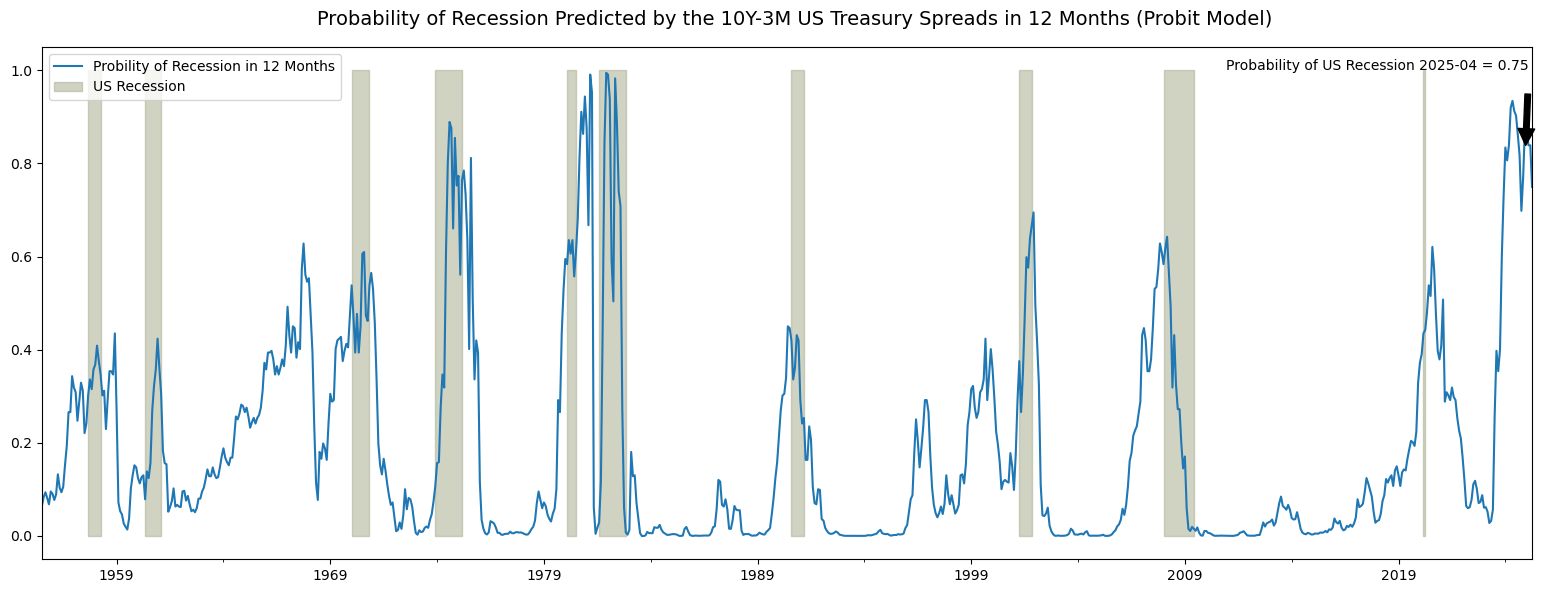

In [33]:
from pandas import DateOffset

feature = ["UST_10Y_3M"]
last_12M_data = data[feature].iloc[-12:]
last_12M_data.index = last_12M_data.index + DateOffset(months=12)
pred_data = pd.concat([X_shifted_12M[feature], last_12M_data])

model = sm.Probit(endog = y, exog = X_shifted_12M[feature]).fit(disp=0)
pred_prob = model.predict(pred_data)
latest = pred_prob.index.strftime("%Y-%m")[-1]

fill_range = y
max_y = 1
min_y = 0

fig, ax = plt.subplots(figsize = (16, 6))
fig.suptitle("Probability of Recession Predicted by the 10Y-3M US Treasury Spreads in 12 Months (Probit Model)", fontsize=14)
pred_prob.plot(ax =ax)
ax.fill_between(fill_range.index, min_y, max_y, where = fill_range.values, color=fill_color_1, alpha=0.6, label = fill_USREC)
ax.set_xlabel("")

ax.annotate('Probability of US Recession '+str(latest)+" = " + str(round(pred_prob.iloc[-1],2)), xy=("2024-12-31", 0.8), xytext=("2010-12-31", 1), arrowprops=dict(facecolor='black', shrink=0.2))
plt.legend(loc = 'upper left', labels = ["Probility of Recession in 12 Months", "US Recession"])
plt.tight_layout()
plt.show()